# Simple logistic regression

This notebook follows John H McDonald's [Handbook of Biological Statistics](http://www.biostathandbook.com/simplelogistic.html) chapter on simple logistic regression.

This notebook is provided with a CC-BY-SA license.

In [1]:
%matplotlib inline

In [2]:
import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import scipy.special
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

Spider data from *Suzuki et al. (2006)*:

In [3]:
data = """Grain size (mm)	Spiders
0.245	absent
0.247	absent
0.285	present
0.299	present
0.327	present
0.347	present
0.356	absent
0.36	present
0.363	absent
0.364	present
0.398	absent
0.4	present
0.409	absent
0.421	present
0.432	absent
0.473	present
0.509	present
0.529	present
0.561	absent
0.569	absent
0.594	present
0.638	present
0.656	present
0.816	present
0.853	present
0.938	present
1.036	present
1.045	present
"""
df = pd.read_table(io.StringIO(data))
df.Spiders = df.Spiders == 'present'
df.head()

,Grain size (mm),Spiders
0,0.245,False
1,0.247,False
2,0.285,True
3,0.299,True
4,0.327,True


KeyError: 'Spiders'

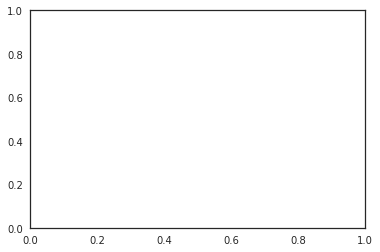

In [4]:
df.plot.scatter('Grain size (mm)', 'Spiders')
plt.ylabel('Spiders present?')
sns.despine()

I will analyse this with the *scikit-learn* package.

In [ ]:
import sklearn.linear_model

scikit-learn has a logisitic regression classifier which uses regularization. To eliminate regularization, we set the regularization parameter `C` to $10^{12}$.

In [ ]:
# C=1e12 is effectively no regularization - see https://github.com/scikit-learn/scikit-learn/issues/6738
clf = sklearn.linear_model.LogisticRegression(C=1e12, random_state=0)
clf.fit(df['Grain size (mm)'].reshape(-1, 1), df['Spiders'])
print(clf.intercept_, clf.coef_)

This is in agreement with the equation John reports:
$$
probability of spider presence = \frac{e^{-1.6476+5.1215(grain \; size)}}{(1+e^{-1.6476+5.1215(grain \; size)}}
$$

In [ ]:
def plot_log_reg(x, y, data, clf, xmin=None, xmax=None, alpha=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.scatter(data[x], data[y], color='black', zorder=20, alpha=alpha)
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    X_test = np.linspace(xmin, xmax, 300)

    loss = scipy.special.expit(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.plot(X_test, loss, linewidth=3)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fig.tight_layout()
    sns.despine()
    return fig, ax

In [ ]:
plot_log_reg(x='Grain size (mm)', y='Spiders', data=df, clf=clf, xmin=0, xmax=1.5);

# Hypothesis testing

To test if *Grain size* is a significant factor, we use the [**likelihood ratio test**](https://en.wikipedia.org/wiki/Logistic_regression#Evaluating_goodness_of_fit).

We calculate the likelihood of the model with the grain size (the alternative model):

In [ ]:
def log_reg_null_model(y):
    clf = sklearn.linear_model.LogisticRegression(C=1e12)
    clf.fit(np.zeros_like(y).reshape(-1, 1), y)
    return clf

clf0 = log_reg_null_model(df['Spiders'])

The likelihood ratio test operates by calculating the test statistic $D$ from the likelihoods of the null and alternative models:
$$
D = -2 \log{ \frac{L(H_0)}{L(H_1)} }
$$
The test statistic is then approximately chisquare distributed.

*scikit-learn* has a log-loss function that can help us do that. 
The log-loss is defined as the negative log-likelihood, so we can rewrite:
$$
D = 2 (-\log{L(H_0)} + \log{L(H_1)}) \Rightarrow \\
D = 2 (logloss(H_0) - logloss(H_1))
$$

In [ ]:
import sklearn.metrics

In [ ]:
def log_reg_lik_ratio_test(X, Y, clf0, clf1, df=1):
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    y_prob0 = clf0.predict_proba(X)
    loss0 = sklearn.metrics.log_loss(Y, y_prob0, normalize=False)
    y_prob1 = clf1.predict_proba(X)
    loss1 = sklearn.metrics.log_loss(Y, y_prob1, normalize=False)
    D = 2 * (loss0 - loss1)
    return scipy.stats.distributions.chi2.sf(D, df=df)

In [ ]:
log_reg_lik_ratio_test(df['Grain size (mm)'], df['Spiders'].astype(np.float64), clf0, clf)

John indeed reports 0.033.

Note that the log-loss calculation in equivalent to:

In [ ]:
_ = clf.predict_proba(df['Grain size (mm)'].reshape(-1, 1))
df['prob_absent'], df['prob_present'] = _[:,0], _[:,1]
lik = df.loc[df['Spiders'], 'prob_present'].prod() * df.loc[~df['Spiders'], 'prob_absent'].prod()
print(
    -np.log(lik), 
    sklearn.metrics.log_loss(
        df['Spiders'], 
        clf.predict_proba(df['Grain size (mm)'].reshape(-1, 1)), 
        normalize=False
    )
)

## Second example

In [ ]:
data = """Location	Latitude	Mpi90	Mpi100	p, Mpi100
Port Townsend, WA	48.1	47	139	0.748
Neskowin, OR	45.2	177	241	0.577
Siuslaw R., OR	44	1087	1183	0.521
Umpqua R., OR	43.7	187	175	0.483
Coos Bay, OR	43.5	397	671	0.628
San Francisco, CA	37.8	40	14	0.259
Carmel, CA	36.6	39	17	0.304
Santa Barbara, CA	34.3	30	0	0
"""
df = pd.read_table(io.StringIO(data))
df.head()

In [ ]:
df.sort_values('Latitude').plot('Latitude', 'p, Mpi100', ls='', marker='o')
plt.ylabel('Mpi100 proportion')
plt.legend().set_visible(False)
plt.xlim(30, 50)
plt.ylim(-0.1, 1.1)
sns.despine()

In [ ]:
rows = []
for i, row in df.iterrows():
    for _ in range(row['Mpi90']):
        rows.append({'Location':row['Location'], 'Latitude': row['Latitude'], 'Allele': 0})
    for _ in range(row['Mpi100']):
        rows.append({'Location':row['Location'], 'Latitude': row['Latitude'], 'Allele': 1})
raw_df = pd.DataFrame(rows)
raw_df.head()

In [ ]:
clf = sklearn.linear_model.LogisticRegression(C=1e12, random_state=0)
clf.fit(raw_df['Latitude'].reshape(-1, 1), raw_df['Allele'])
print(clf.intercept_, clf.coef_)

which is very close to McDonald's intercept of -7.6469 and slope of 0.1786.

In [ ]:
fig, ax = plot_log_reg(x='Latitude', y='Allele', data=raw_df, clf=clf, xmin=30, xmax=50, alpha=0.02)
df.sort_values('Latitude').plot('Latitude', 'p, Mpi100', ls='', marker='o', ax=ax)

In [ ]:
clf0 = log_reg_null_model(raw_df['Allele'])
print(clf0.intercept_, clf0.coef_)

In [ ]:
log_reg_lik_ratio_test(raw_df['Latitude'], raw_df['Allele'], clf0, clf)